## 1. Učitavanje potrebnih paketa

In [64]:
# Standardne biblioteke
import sys
sys.path.append('../../')

import itertools

# Analiza podataka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# FinRL i stable_baselines3 za strojno učenje i trgovanje
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_primo_trading.env_primorl import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from stable_baselines3.common.logger import configure

# Konfiguracijski fajlovi i pomoćne funkcije iz FinRL
from finrl.config import INDICATORS, FUNDAMENTAL_INDICATORS
from finrl.main import check_and_make_directories

# Omogućavanje prikaza grafikona unutar Jupyter bilježnice
%matplotlib inline

TRAINED_MODEL_DIR = 'files/models_PORTFOLIO'
RESULTS_DIR = 'files/results_PORTFOLIO'
DATA_DIR = 'files/data_PORTFOLIO'

# Provjera i kreiranje direktorija
check_and_make_directories([TRAINED_MODEL_DIR, DATA_DIR])

## 2. Dohvat podataka

In [65]:
# Intervali za trening i trgovanje
TRAIN_START_DATE = '2022-04-01'
TRAIN_END_DATE = '2024-07-31'
TRADE_START_DATE = '2024-08-01'
TRADE_END_DATE = '2025-02-28'

In [66]:
# Lista dionica
stocks = ["AAPL", "NFLX", "MSFT", "CRM", "AMZN"]

# Učitavanje podataka za svaku dionicu
for stock in stocks:
    file_path = f'data/{stock}_data.csv'
    df_name = f'gpt_predictions_{stock.lower()}'
    
    # Učitavanje CSV datoteke
    globals()[df_name] = pd.read_csv(file_path)
    
    # Preimenovanje stupca 'Date' u 'date'
    globals()[df_name] = globals()[df_name].rename(columns={'Date': 'date'})
    
    # Dodavanje stupca 'tic' s oznakom dionice
    globals()[df_name]['tic'] = stock

In [67]:
gpt_predictions_aapl.head()


,date,Adj Close Price,Returns,Bin Label,News Relevance,Sentiment,Price Impact Potential,Trend Direction,Earnings Impact,Investor Confidence,Risk Profile Change,Prompt,tic
0,2022-04-04,175.594757,0.023693,U3,0,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...,AAPL
1,2022-04-05,172.268631,-0.018942,D2,2,0,-1,0,0,0,0,\n [COMPANY BASICS]\n ...,AAPL
2,2022-04-06,169.090149,-0.018451,D2,2,0,-1,-1,0,-1,-1,\n [COMPANY BASICS]\n ...,AAPL
3,2022-04-07,169.395187,0.001804,U1,0,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...,AAPL
4,2022-04-08,167.377869,-0.011909,D2,0,0,0,0,0,0,0,\n [COMPANY BASICS]\n ...,AAPL


In [68]:
# Preuzimamo sve podatke
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                         end_date = TRADE_END_DATE,
                         ticker_list = ["AAPL", "NFLX", "MSFT", "CRM", "AMZN"]).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (3645, 8)


In [69]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2022-04-01,171.530594,174.309998,174.880005,174.029999,78751300,AAPL,4
1,2022-04-01,163.559998,163.559998,165.826996,164.149506,57090000,AMZN,4
2,2022-04-01,211.071091,212.250000,214.029999,212.479996,6007900,CRM,4
3,2022-04-01,301.616913,309.420013,310.130005,309.369995,27110500,MSFT,4
4,2022-04-01,373.470001,373.470001,380.869995,376.799988,4644200,NFLX,4


## 3. Procesiranje podataka

In [70]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

[*********************100%***********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (728, 8)
Successfully added vix


Successfully added turbulence index


In [71]:
# Stvara listu jedinstvenih oznaka dionica (tickers) iz stupca 'tic' DataFrame-a 'processed'.
list_ticker = processed["tic"].unique().tolist()

# Stvara listu datuma između najranijeg i najkasnijeg datuma u DataFrame-u 'processed', pretvara ih u stringove.
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))

# Stvara kombinacije svih datuma i oznaka dionica koristeći kartezijev produkt.
combination = list(itertools.product(list_date,list_ticker))

# Stvara novi DataFrame 'processed_full' s kolonama "date" i "tic", koji sadrži sve kombinacije datuma i oznaka dionica.
# Spaja taj DataFrame s originalnim DataFrame-om 'processed' na temelju kolona "date" i "tic", koristeći 'left' spajanje.
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")

# Filtrira 'processed_full' DataFrame da sadrži samo one retke čiji su datumi prisutni u originalnom DataFrame-u 'processed'.
processed_full = processed_full[processed_full['date'].isin(processed['date'])]

# Sortira 'processed_full' DataFrame po datumu i oznaci dionica.
processed_full = processed_full.sort_values(['date','tic'])

# Zamjenjuje sve nedostajuće vrijednosti (NaN) s 0 u DataFrame-u 'processed_full'.
processed_full = processed_full.fillna(0)

In [72]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-04-01,AAPL,171.530594,174.309998,174.880005,174.029999,78751300.0,4.0,0.0,175.06369,173.536316,100.0,66.666667,100.0,174.029999,174.029999,20.620001,0.0
1,2022-04-01,AMZN,163.559998,163.559998,165.826996,164.149506,57090000.0,4.0,0.0,175.06369,173.536316,100.0,66.666667,100.0,164.149506,164.149506,20.620001,0.0
2,2022-04-01,CRM,211.071091,212.250000,214.029999,212.479996,6007900.0,4.0,0.0,175.06369,173.536316,100.0,66.666667,100.0,212.479996,212.479996,20.620001,0.0
3,2022-04-01,MSFT,301.616913,309.420013,310.130005,309.369995,27110500.0,4.0,0.0,175.06369,173.536316,100.0,66.666667,100.0,309.369995,309.369995,20.620001,0.0
4,2022-04-01,NFLX,373.470001,373.470001,380.869995,376.799988,4644200.0,4.0,0.0,175.06369,173.536316,100.0,66.666667,100.0,376.799988,376.799988,20.620001,0.0


In [73]:
# Stupci koje želimo zadržati iz GPT predikcija
columns_to_keep = ['date', 'News Relevance', 'Sentiment', 'Price Impact Potential', 
                   'Trend Direction', 'Earnings Impact', 'Investor Confidence', 'Risk Profile Change']

# Mapiranje za preimenovanje stupaca
column_mapping = {
    'News Relevance': 'news_relevance',
    'Sentiment': 'sentiment',
    'Price Impact Potential': 'price_impact_potential',
    'Trend Direction': 'trend_direction',
    'Earnings Impact': 'earnings_impact',
    'Investor Confidence': 'investor_confidence',
    'Risk Profile Change': 'risk_profile_change'
}

# Priprema podataka za AAPL
gpt_data_aapl = gpt_predictions_aapl[columns_to_keep]
gpt_data_aapl = gpt_data_aapl.rename(columns=column_mapping)
gpt_data_aapl['tic'] = 'AAPL'

# Spajanje podataka samo za AAPL redove
processed_full = processed_full.merge(gpt_data_aapl, on=['date', 'tic'], how='left')

# Popunjavanje NaN vrijednosti s 0 samo za nove stupce
new_columns = list(column_mapping.values())
processed_full[new_columns] = processed_full[new_columns].fillna(0)


In [74]:
# Mapiranje za preimenovanje stupaca
column_mapping = {
    'News Relevance': 'news_relevance',
    'Sentiment': 'sentiment',
    'Price Impact Potential': 'price_impact_potential',
    'Trend Direction': 'trend_direction',
    'Earnings Impact': 'earnings_impact',
    'Investor Confidence': 'investor_confidence',
    'Risk Profile Change': 'risk_profile_change'
}

# Priprema podataka za NFLX
gpt_data_nflx = gpt_predictions_nflx[['date'] + list(column_mapping.keys())]
gpt_data_nflx = gpt_data_nflx.rename(columns=column_mapping)
gpt_data_nflx['tic'] = 'NFLX'

# Ažuriranje podataka samo za NFLX redove
for column in column_mapping.values():
    processed_full.loc[processed_full['tic'] == 'NFLX', column] = processed_full.loc[processed_full['tic'] == 'NFLX'].merge(
        gpt_data_nflx[['date', 'tic', column]], 
        on=['date', 'tic'], 
        how='left'
    )[f'{column}_y'].fillna(processed_full[column])

In [75]:
# Mapiranje za preimenovanje stupaca
column_mapping = {
    'News Relevance': 'news_relevance',
    'Sentiment': 'sentiment',
    'Price Impact Potential': 'price_impact_potential',
    'Trend Direction': 'trend_direction',
    'Earnings Impact': 'earnings_impact',
    'Investor Confidence': 'investor_confidence',
    'Risk Profile Change': 'risk_profile_change'
}

# Priprema podataka za NFLX
gpt_data_msft = gpt_predictions_msft[['date'] + list(column_mapping.keys())]
gpt_data_msft = gpt_data_msft.rename(columns=column_mapping)
gpt_data_msft['tic'] = 'MSFT'

# Ažuriranje podataka samo za NFLX redove
for column in column_mapping.values():
    processed_full.loc[processed_full['tic'] == 'MSFT', column] = processed_full.loc[processed_full['tic'] == 'MSFT'].merge(
        gpt_data_msft[['date', 'tic', column]], 
        on=['date', 'tic'], 
        how='left'
    )[f'{column}_y'].fillna(processed_full[column])

In [76]:
# Mapiranje za preimenovanje stupaca
column_mapping = {
    'News Relevance': 'news_relevance',
    'Sentiment': 'sentiment',
    'Price Impact Potential': 'price_impact_potential',
    'Trend Direction': 'trend_direction',
    'Earnings Impact': 'earnings_impact',
    'Investor Confidence': 'investor_confidence',
    'Risk Profile Change': 'risk_profile_change'
}

# Priprema podataka za NFLX
gpt_data_crm = gpt_predictions_crm[['date'] + list(column_mapping.keys())]
gpt_data_crm = gpt_data_crm.rename(columns=column_mapping)
gpt_data_crm['tic'] = 'CRM'

# Ažuriranje podataka samo za NFLX redove
for column in column_mapping.values():
    processed_full.loc[processed_full['tic'] == 'CRM', column] = processed_full.loc[processed_full['tic'] == 'CRM'].merge(
        gpt_data_crm[['date', 'tic', column]], 
        on=['date', 'tic'], 
        how='left'
    )[f'{column}_y'].fillna(processed_full[column])

In [77]:
# Mapiranje za preimenovanje stupaca
column_mapping = {
    'News Relevance': 'news_relevance',
    'Sentiment': 'sentiment',
    'Price Impact Potential': 'price_impact_potential',
    'Trend Direction': 'trend_direction',
    'Earnings Impact': 'earnings_impact',
    'Investor Confidence': 'investor_confidence',
    'Risk Profile Change': 'risk_profile_change'
}

# Priprema podataka za NFLX
gpt_data_amzn = gpt_predictions_amzn[['date'] + list(column_mapping.keys())]
gpt_data_amzn = gpt_data_amzn.rename(columns=column_mapping)
gpt_data_amzn['tic'] = 'AMZN'

# Ažuriranje podataka samo za NFLX redove
for column in column_mapping.values():
    processed_full.loc[processed_full['tic'] == 'AMZN', column] = processed_full.loc[processed_full['tic'] == 'AMZN'].merge(
        gpt_data_amzn[['date', 'tic', column]], 
        on=['date', 'tic'], 
        how='left'
    )[f'{column}_y'].fillna(processed_full[column])

In [78]:
# Zamjenjuje sve nedostajuće vrijednosti (NaN) s 0 u DataFrame-u 'processed_full'.
processed_full = processed_full.fillna(0)

In [79]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,close_60_sma,vix,turbulence,news_relevance,sentiment,price_impact_potential,trend_direction,earnings_impact,investor_confidence,risk_profile_change
0,2022-04-01,AAPL,171.530594,174.309998,174.880005,174.029999,78751300.0,4.0,0.0,175.06369,...,174.029999,20.620001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-04-01,AMZN,163.559998,163.559998,165.826996,164.149506,57090000.0,4.0,0.0,175.06369,...,164.149506,20.620001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-04-01,CRM,211.071091,212.250000,214.029999,212.479996,6007900.0,4.0,0.0,175.06369,...,212.479996,20.620001,0.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0
3,2022-04-01,MSFT,301.616913,309.420013,310.130005,309.369995,27110500.0,4.0,0.0,175.06369,...,309.369995,20.620001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-04-01,NFLX,373.470001,373.470001,380.869995,376.799988,4644200.0,4.0,0.0,175.06369,...,376.799988,20.620001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
# Pripremamo trening i trade set sukladno definiranim datumima
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

2920
715


In [81]:
# Spremamo podatke
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

## 4. Priprema environmenta

In [82]:
# Izračunavamo dimenziju (broj jedinstvenih dionica) iz DataFrame-a 'train'.
stock_dimension = len(train.tic.unique())

# Izračunavamo veličinu stanja na temelju dimenzije i broja tehničkih indikatora.
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + len(FUNDAMENTAL_INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 86


In [83]:
# Stvara liste troškova kupnje i prodaje za svaku dionicu.
buy_cost_list = sell_cost_list = [0] * stock_dimension

# Inicijalizira broj dionica za svaku dionicu na 0.
num_stock_shares = [0] * stock_dimension

In [84]:
# Definira argumente za okruženje trgovanja.
env_kwargs = {
    "hmax": 1000,  # Maksimalni broj dionica koje se mogu kupiti ili prodati u jednoj transakciji.
    "initial_amount": 100000,  # Početni iznos kapitala.
    "num_stock_shares": num_stock_shares,  # PPočetni broj dionica svake dionice u portfelju, inicijalno postavljen na 0.
    "buy_cost_pct": buy_cost_list,  # Postotci troškova za kupnju i prodaju dionica, odnosno, koji simuliraju stvarne troškove transakcija.
    "sell_cost_pct": sell_cost_list,  # Postotci troškova za kupnju i prodaju dionica, odnosno, koji simuliraju stvarne troškove transakcija.
    "state_space": state_space,  # Prije definirane veličine koje utječu na strukturu okruženja.
    "stock_dim": stock_dimension,  # Prije definirane veličine koje utječu na strukturu okruženja.
    "tech_indicator_list": INDICATORS,  # Lista tehničkih indikatora koji će se koristiti za analizu stanja tržišta.
    "fundamental_indicator_list": FUNDAMENTAL_INDICATORS,  # Lista fundamentalnih indikatora koji će se koristiti za analizu stanja tržišta.
    "action_space": stock_dimension,  # Veličina prostora akcija, odnosno, broj različitih akcija koje model može izvršiti.
    "reward_scaling": 1e-2,  # Faktor skaliranja za nagradu, koristi se za prilagodbu veličine nagrade kako bi se olakšalo učenje.
    "verbose": 0
}

# Kreira okruženje za treniranje.
e_train_gym = StockTradingEnv(df = train, **env_kwargs)

# Dohvaća okruženje pogodno za Stable Baselines i neiskorišteni objekt.
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## 5. Trening DRL agenata

In [85]:
# Kreira instancu DRL agenta s predanim okruženjem za treniranje.
agent = DRLAgent(env = env_train)

# Postavljanje odgovarajućih vrijednosti na 'True' za algoritme koje želite koristiti
if_using_a2c = True
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = True

### Trening 5 različitih DRL agenata (A2C, DDPG, PPO, TD3, SAC)

#### Agent 1: A2C

In [86]:
# Ponovno se kreira instanca DRL agenta s predanim okruženjem (nije potrebno ponovno raditi, ali zbog lakših uputa neka stoji)
agent = DRLAgent(env = env_train)
# Dohvaća model A2C pomoću metode get_model
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # Postavljanje loggera za praćenje i zapisivanje informacija tijekom treniranja
  tmp_path = RESULTS_DIR + '/a2c'
  # Konfigurira novi logger koji će ispisivati informacije na standardni izlaz, zapisivati u CSV datoteku i TensorBoard
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Postavlja novi logger za model A2C.
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to files/results_PORTFOLIO/a2c


In [87]:
# Trenira model A2C s definiranim ukupnim brojem vremenskih koraka, samo ako je if_using_a2c postavljen na True.
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=50000) if if_using_a2c else None

---------------------------------------
| time/                 |             |
|    fps                | 493         |
|    iterations         | 100         |
|    time_elapsed       | 1           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -7.11       |
|    explained_variance | -4.79       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -0.00203    |
|    reward             | 0.001506285 |
|    std                | 1           |
|    value_loss         | 1.07e-06    |
---------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 570          |
|    iterations         | 200          |
|    time_elapsed       | 1            |
|    total_timesteps    | 1000         |
| train/                |              |
|    entropy_loss       | -7.2         |
|    explained_variance | -650  

In [88]:
# Sprema trenirani model A2C u definirani direktorij, samo ako je if_using_a2c postavljen na True.
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

#### Agent 2: DDPG

In [89]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [90]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

In [91]:

trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

#### Agent 3: PPO

In [92]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to files/results_PORTFOLIO/ppo


In [93]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=400000) if if_using_ppo else None

Day: 583, episode: 90
Begin total asset: 100000.00
End total asset: 123011.11
Total reward: 23011.11
Total cost: 0.00
Total trades: 941
Sharpe: 0.435
-------------------------------------
| time/              |              |
|    fps             | 1314         |
|    iterations      | 1            |
|    time_elapsed    | 1            |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | 0.0010595274 |
-------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1273         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.006282635  |
|    clip_fraction        | 0.0505       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.09        |
|    explained_variance   | -16    

In [94]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

#### Agent 4: TD3

In [95]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [96]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

In [97]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

#### Agent 5: SAC

In [98]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to files/results_PORTFOLIO/sac


In [99]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

-------------------------------------
| time/              |              |
|    episodes        | 4            |
|    fps             | 182          |
|    time_elapsed    | 12           |
|    total_timesteps | 2336         |
| train/             |              |
|    actor_loss      | 81.2         |
|    critic_loss     | 31.6         |
|    ent_coef        | 0.122        |
|    ent_coef_loss   | 39.6         |
|    learning_rate   | 0.0001       |
|    n_updates       | 2235         |
|    reward          | 0.0021546711 |
-------------------------------------
Day: 583, episode: 780
Begin total asset: 100000.00
End total asset: 100000.00
Total reward: 0.00
Total cost: 0.00
Total trades: 0
-------------------------------------
| time/              |              |
|    episodes        | 8            |
|    fps             | 178          |
|    time_elapsed    | 26           |
|    total_timesteps | 4672         |
| train/             |              |
|    actor_loss      | 109       

In [100]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## 6. Priprema za backtest

In [101]:
# Po potrebi učitavamo sporemnjene podatke ako smo restrartali proces (nije potrebno)
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [102]:
# Po potrebi učitavamo sporemnjene podatke o treningu agenata ako smo restrartali proces (nije potrebno)
if_using_a2c = True
if_using_ddpg = False
if_using_ppo = True
if_using_td3 = False
if_using_sac = True

trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

## 7. Trgovanje (podatci izvan trening seta)

In [103]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + len(FUNDAMENTAL_INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 86


In [104]:
buy_cost_list = sell_cost_list = [0] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 1000,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "fundamental_indicator_list": FUNDAMENTAL_INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-2,
    "verbose": 1
}

In [105]:
# Inicijalizacija okruženja za trgovanje s definiranim DataFrame-om 'trade', pragom turbulencije i pokazateljem rizika 'vix',
# zajedno s ostalim parametrima okruženja ('env_kwargs').
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

# Dohvaćanje okruženja kompatibilnog sa Stable Baselines i početne opservacije.
env_trade, obs_trade = e_trade_gym.get_sb_env()

Initialized environment with 5 stocks
Technical indicators: ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
Fundamental indicators: ['news_relevance', 'sentiment', 'price_impact_potential', 'trend_direction', 'earnings_impact', 'investor_confidence', 'risk_profile_change']
Initial amount: 100000
Initial stock shares: [0, 0, 0, 0, 0]

Resetting environment. Episode: 0
Initial state: [100000, 224.3699951171875, 189.2899932861328, 259.8999938964844, 420.7900085449219, 629.25, 0, 0, 0, 0, 0, 2.126394158659565, -1.4880838494052, 1.992131480804062, -5.698224510982641, -8.275158170090322, 236.6916214179612, 204.4031765534138, 263.9797025677689, 475.36585953253143, 694.3501419546789, 215.0363754082107, 175.9678210662151, 247.07229480771932, 411.931137537781, 613.2148543832117, 59.41505885082817, 52.09421048472728, 51.074586998981154, 45.1358796499111, 46.82963360614803, 3.2523612098087105, -36.67615862181392, 64.78367490131666, -151.8835803188917, -1

In [106]:
# Korištenje DRL agenta za predviđanje koristeći trenirani model 'trained_a2c' i definirano okruženje trgovanja 'e_trade_gym'.
# Rezultati su dva DataFrame-a: 'df_account_value_a2c' s vrijednostima računa i 'df_actions_a2c' s akcijama koje su poduzete,
# ako je 'if_using_a2c' postavljen na True; inače se vraća (None, None).
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)


Resetting environment. Episode: 1
Initial state: [100000, 224.3699951171875, 189.2899932861328, 259.8999938964844, 420.7900085449219, 629.25, 0, 0, 0, 0, 0, 2.126394158659565, -1.4880838494052, 1.992131480804062, -5.698224510982641, -8.275158170090322, 236.6916214179612, 204.4031765534138, 263.9797025677689, 475.36585953253143, 694.3501419546789, 215.0363754082107, 175.9678210662151, 247.07229480771932, 411.931137537781, 613.2148543832117, 59.41505885082817, 52.09421048472728, 51.074586998981154, 45.1358796499111, 46.82963360614803, 3.2523612098087105, -36.67615862181392, 64.78367490131666, -151.8835803188917, -107.9104917756248, 25.936353706710108, 11.117011520494843, 6.268014844367653, 1.4537879558832925, 20.337777268223736, 221.6223317464193, 190.69766591389973, 252.6353332519531, 445.9666656494141, 661.8606628417969, 207.83049850463868, 187.2703333536784, 255.39500071207684, 435.0696665445964, 648.794834391276, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 

In [107]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

In [108]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)


Resetting environment. Episode: 4
Initial state: [100000, 224.3699951171875, 189.2899932861328, 259.8999938964844, 420.7900085449219, 629.25, 0, 0, 0, 0, 0, 2.126394158659565, -1.4880838494052, 1.992131480804062, -5.698224510982641, -8.275158170090322, 236.6916214179612, 204.4031765534138, 263.9797025677689, 475.36585953253143, 694.3501419546789, 215.0363754082107, 175.9678210662151, 247.07229480771932, 411.931137537781, 613.2148543832117, 59.41505885082817, 52.09421048472728, 51.074586998981154, 45.1358796499111, 46.82963360614803, 3.2523612098087105, -36.67615862181392, 64.78367490131666, -151.8835803188917, -107.9104917756248, 25.936353706710108, 11.117011520494843, 6.268014844367653, 1.4537879558832925, 20.337777268223736, 221.6223317464193, 190.69766591389973, 252.6353332519531, 445.9666656494141, 661.8606628417969, 207.83049850463868, 187.2703333536784, 255.39500071207684, 435.0696665445964, 648.794834391276, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 

In [109]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

In [110]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)


Resetting environment. Episode: 7
Initial state: [100000, 224.3699951171875, 189.2899932861328, 259.8999938964844, 420.7900085449219, 629.25, 0, 0, 0, 0, 0, 2.126394158659565, -1.4880838494052, 1.992131480804062, -5.698224510982641, -8.275158170090322, 236.6916214179612, 204.4031765534138, 263.9797025677689, 475.36585953253143, 694.3501419546789, 215.0363754082107, 175.9678210662151, 247.07229480771932, 411.931137537781, 613.2148543832117, 59.41505885082817, 52.09421048472728, 51.074586998981154, 45.1358796499111, 46.82963360614803, 3.2523612098087105, -36.67615862181392, 64.78367490131666, -151.8835803188917, -107.9104917756248, 25.936353706710108, 11.117011520494843, 6.268014844367653, 1.4537879558832925, 20.337777268223736, 221.6223317464193, 190.69766591389973, 252.6353332519531, 445.9666656494141, 661.8606628417969, 207.83049850463868, 187.2703333536784, 255.39500071207684, 435.0696665445964, 648.794834391276, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 

## 8. Mean Variance optimizacija

In [111]:
# Funkcija za pripremu DataFrame-a za izračun težina optimizacije srednje varijance (MVO)
def process_df_for_mvo(df):
  # Sortira DataFrame po datumu i oznaci dionice, a zatim selektira samo relevantne stupce
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  # Uzima podskup podataka za prvu dimenziju dionica
  fst = df.iloc[0:stock_dimension, :]
  # Izvlači popis oznaka dionica
  tic = fst['tic'].tolist()

  # Inicijalizira prazan DataFrame za MVO
  mvo = pd.DataFrame()

  # Postavlja početne vrijednosti težina na 0 za svaku dionicu
  for k in range(len(tic)):
    mvo[tic[k]] = 0

  # Popunjava DataFrame 'mvo' zatvarajućim cijenama za svaku dionicu po datumima
  for i in range(df.shape[0]//stock_dimension):
    n = df.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()
  
  return mvo

In [112]:
# Funkcija za izračun povrata dionica na temelju njihovih cijena
def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  # Inicijalizira matricu povrata.
  StockReturn = np.zeros([Rows-1, Columns]) 
  # Računa dnevni povrat za svaku dionicu
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):       # i: Daily Prices 
      StockReturn[i,j] = ((StockPrice[i+1, j] - StockPrice[i,j]) / StockPrice[i,j]) * 100 
      
  return StockReturn

In [113]:
# Primjena funkcije na trening i trade
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

# Pretvara TradeData u numpy niz
TradeData.to_numpy()

array([[ 224.37,  189.29,  259.9 ,  420.79,  629.25],
       [ 219.15,  166.75,  247.79,  412.49,  620.98],
       [ 199.09,  154.21,  232.32,  389.17,  587.04],
       [ 205.3 ,  161.71,  241.09,  400.  ,  600.62],
       [ 206.9 ,  166.55,  242.61,  408.64,  616.07],
       [ 213.11,  165.17,  243.24,  402.44,  621.99],
       [ 212.1 ,  166.4 ,  248.7 ,  404.03,  622.99],
       [ 216.07,  168.14,  252.6 ,  407.06,  631.  ],
       [ 219.01,  167.81,  253.  ,  409.59,  638.56],
       [ 220.57,  172.11,  255.39,  414.8 ,  648.7 ],
       [ 224.6 ,  174.86,  257.9 ,  419.8 ,  668.49],
       [ 223.92,  177.04,  261.75,  420.6 ,  669.43],
       [ 225.72,  177.64,  263.1 ,  418.96,  674.07],
       [ 225.77,  177.92,  264.95,  421.7 ,  688.86],
       [ 226.52,  179.92,  261.1 ,  424.08,  697.  ],
       [ 227.79,  181.38,  261.5 ,  424.36,  691.  ],
       [ 225.66,  177.34,  261.99,  416.98,  694.13],
       [ 226.76,  176.7 ,  263.94,  416.37,  687.26],
       [ 226.  ,  174.15,  2

In [114]:
# Izračunava povrat po imovini
arStockPrices = np.asarray(StockData)
[Rows, Cols] = arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

# Izračunava prosječne povrate i kovarijacijsku matricu povrata
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
# Postavlja preciznost za ispis rezultata.
np.set_printoptions(precision=3, suppress = True)

# Prikazuje prosječne povrate i kovarijacijsku matricu povrata
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.055 0.05  0.065 0.071 0.13 ]
Variance-Covariance matrix of returns
 [[3.042 2.356 1.884 1.843 2.037]
 [2.356 5.98  3.237 2.787 2.975]
 [1.884 3.237 6.1   2.237 2.447]
 [1.843 2.787 2.237 2.997 2.038]
 [2.037 2.975 2.447 2.038 8.125]]


### Korsitimo sada PyPortfolioOpt

In [115]:
# Učitavanje klase EfficientFrontier iz PyPortfolioOpt biblioteke
from pypfopt.efficient_frontier import EfficientFrontier

# Inicijalizacija objekta EfficientFrontier s prosječnim povratima i kovarijacijskom matricom povrata
# Ograničenja težine su postavljena tako da nijedna imovina ne može činiti više od 50% portfelja
ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))

# Izračunavanje sirovih težina za maksimalni Sharpeov omjer
raw_weights_mean = ef_mean.max_sharpe()

# Čišćenje težina kako bi se zaokružile vrlo male težine na 0 i normalizirale ostale
cleaned_weights_mean = ef_mean.clean_weights()

# Pretvorba čistih težina u stvarne iznose ulaganja, pretpostavljajući početni kapital od 1,000,000
mvo_weights = np.array([100000 * cleaned_weights_mean[i] for i in range(5)])
print(mvo_weights)

# Izračunavanje cijene posljednje dionice u datasetu kako bi se odredile početne količine dionica.
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])

# Izračunavanje početnog portfelja množenjem iznosa ulaganja s posljednjom cijenom.
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
print(Initial_Portfolio)

# Izračunavanje vrijednosti portfelja koristeći trgovinske podatke i početne količine dionica.
Portfolio_Assets = TradeData @ Initial_Portfolio

# Stvaranje DataFrame-a s rezultatima optimizacije srednje varijance.
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
print(MVO_result)

[ 5436.     0.  1114. 50000. 43450.]
[ 24.8     0.      4.291 116.899  68.95 ]
                 Mean Var
2024-08-01   99256.126281
2024-08-02   97534.227504
2024-08-05   91904.120491
2024-08-06   94298.113186
2024-08-07   96419.596963
...                   ...
2025-02-20  127849.788793
2025-02-21  127233.063667
2025-02-24  124666.636866
2025-02-25  122571.521042
2025-02-26  121333.181784

[143 rows x 1 columns]


## 9. DJI indeks za usporedbu

In [116]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['^DJI']).fetch_data()

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (144, 8)


In [117]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(100000), 
               how='outer', left_index=True, right_index=True).set_index('date')

## 10. Provodima backetinskg modela

In [118]:
# Postavljanje indeksa DataFrame-ova vrijednosti računa za svaku od DRL strategija, ako su odabrane.
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

# Kreiranje praznog DataFrame-a za rezultate.
result = pd.DataFrame()

# Spajanje rezultata svih DRL strategija u jedan DataFrame, ako su odabrane.
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True, suffixes=('', '_drop'))

# Spajanje rezultata optimizacije srednje varijance i indeksa DJIA s glavnim rezultatima.
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_60945/3791775406.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


In [119]:
# Dodavanje imena stupaca na temelju odabranih strategija.
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
col_name.append('DJI') 
result.columns = col_name

In [120]:
# Prikazivanje rezultata
result.head()

,A2C,PPO,SAC,Mean Var,DJI
date,,,,,
2024-08-01,100000.000000,100000.000000,100000.000000,99256.126281,100000.000000
2024-08-02,95327.219772,95327.219772,98685.036896,97534.227504,97943.071056
2024-08-05,89374.205170,89798.005127,93284.896530,91904.120491,95452.327131
2024-08-06,92749.380951,92297.992065,96201.259659,94298.113186,94670.322190
2024-08-07,93337.902588,94284.595398,96961.375381,96419.596963,95877.330439


### Ovdje plotiramo graf koji pokazuje ukupnu vrijednost portfolija korz vrijeme za pojedinu strategiju i benchmark

In [121]:
# Postavljanje veličine figure za grafikone i crtanje grafikona performansi strategija trgovanja.
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

<Axes: xlabel='date'>

In [122]:
from pyfolio import timeseries
import pandas as pd

# Lista strategija za koje želite generirati statistike
strategies = ['A2C', 'DDPG', 'PPO', 'TD3', 'SAC', "Mean Var", "DJI"]

for strategy in strategies:
    column_name = f'{strategy}'
    if column_name in result.columns:
        # Izračunavanje dnevnih povrata iz vrijednosti portfelja
        result[f'{strategy}_returns'] = result[column_name].pct_change()

/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_60945/3649623815.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  result[f'{strategy}_returns'] = result[column_name].pct_change()
/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_60945/3649623815.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  result[f'{strategy}_returns'] = result[column_name].pct_change()
/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_60945/3649623815.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fil

In [123]:
result.head()

,A2C,PPO,SAC,Mean Var,DJI,A2C_returns,PPO_returns,SAC_returns,Mean Var_returns,DJI_returns
date,,,,,,,,,,
2024-08-01,100000.000000,100000.000000,100000.000000,99256.126281,100000.000000,NaN,NaN,NaN,NaN,NaN
2024-08-02,95327.219772,95327.219772,98685.036896,97534.227504,97943.071056,-0.046728,-0.046728,-0.013150,-0.017348,-0.020569
2024-08-05,89374.205170,89798.005127,93284.896530,91904.120491,95452.327131,-0.062448,-0.058002,-0.054721,-0.057724,-0.025431
2024-08-06,92749.380951,92297.992065,96201.259659,94298.113186,94670.322190,0.037765,0.027840,0.031263,0.026049,-0.008193
2024-08-07,93337.902588,94284.595398,96961.375381,96419.596963,95877.330439,0.006345,0.021524,0.007901,0.022498,0.012750


### Računamo povrate po odabranoj strategiji

In [124]:
# Pretpostavljamo da result DataFrame već sadrži vrijednosti portfelja za svaku strategiju
for strategy in strategies:
    # Provjerite postoji li strategija u DataFrame-u
    if f'{strategy}_returns' in result.columns:
        # Izvlačenje dnevnih povrata za trenutnu strategiju
        returns = result[f'{strategy}_returns'].dropna()
        returns.index = pd.to_datetime(returns.index)

        # Izračunavanje statistika performansi za trenutnu strategiju
        perf_stats = timeseries.perf_stats(returns=returns, factor_returns=None, positions=None, transactions=None, turnover_denom="AGB")

        # Ispis statistika performansi
        print(f"==============Strategy Stats ({strategy})==============")
        print(perf_stats)
        print("\n")
    else:
        print(f"Strategija {strategy} nije pronađena u rezultatima.\n")


==============Strategy Stats (A2C)==============
Annual return          0.384697
Cumulative returns     0.202855
Annual volatility      0.350534
Sharpe ratio           1.101060
Calmar ratio           2.333388
Stability              0.733466
Max drawdown          -0.164866
Omega ratio            1.214984
Sortino ratio          1.729166
Skew                   0.849854
Kurtosis               5.555572
Tail ratio             0.845693
Daily value at risk   -0.042632
dtype: float64


Strategija DDPG nije pronađena u rezultatima.

==============Strategy Stats (PPO)==============
Annual return         -0.137289
Cumulative returns    -0.080385
Annual volatility      0.242502
Sharpe ratio          -0.486698
Calmar ratio          -1.169484
Stability              0.025579
Max drawdown          -0.117393
Omega ratio            0.917501
Sortino ratio         -0.600655
Skew                  -1.263031
Kurtosis               3.250720
Tail ratio             1.004682
Daily value at risk   -0.031021
dtype:

### Plotiramo komulativne povrate za pojedinu strategiju

<Figure size 1500x500 with 0 Axes>

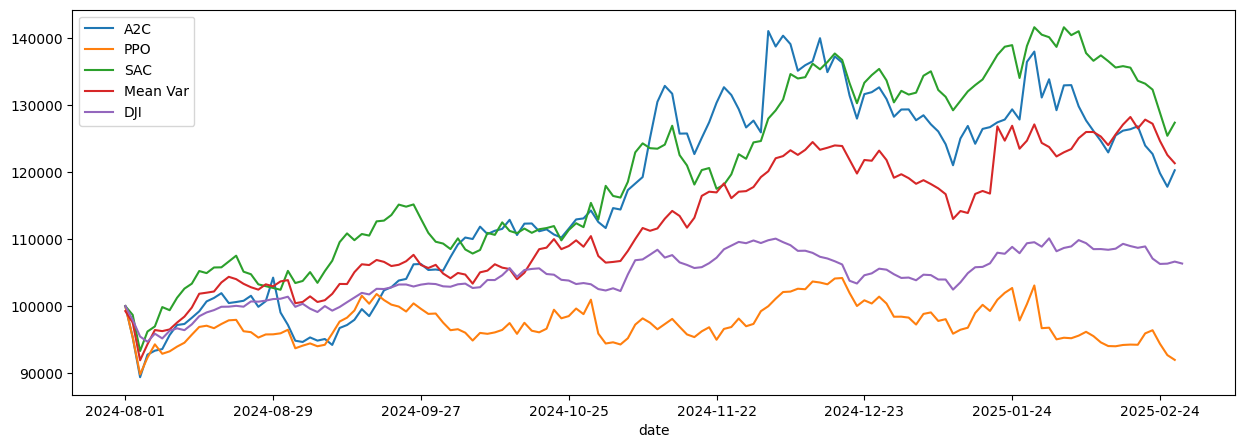

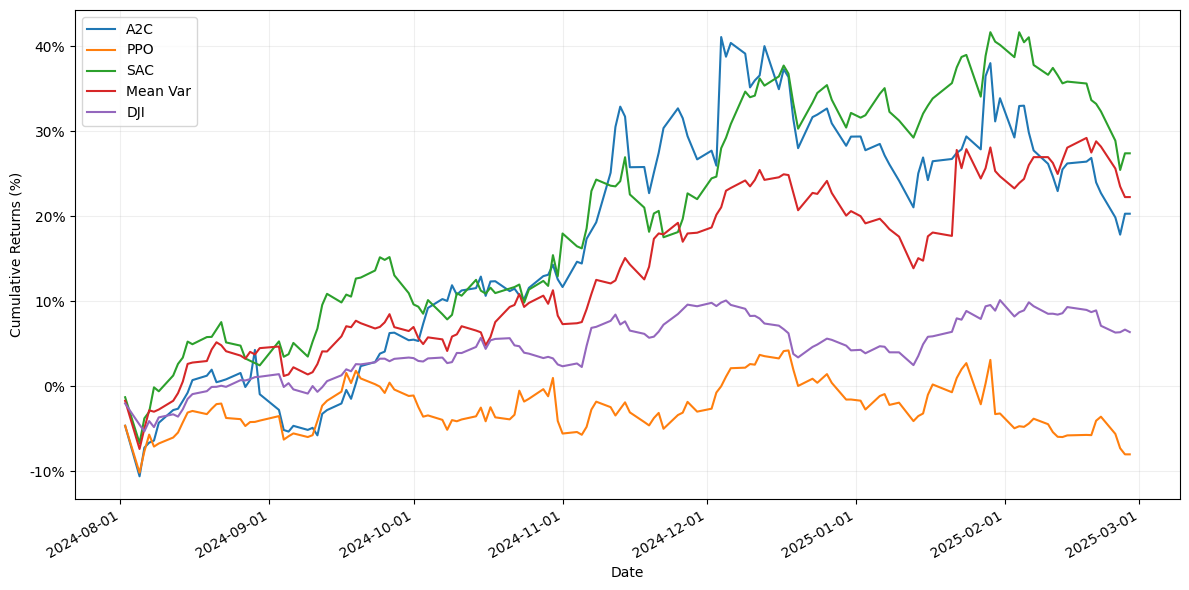

In [125]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Setting the figure size for the plot
plt.figure(figsize=(12, 6))

# Iterating through each strategy and plotting its cumulative returns
for strategy in strategies:
    if f'{strategy}_returns' in result.columns:
        # Make sure dates are properly parsed
        result.index = pd.to_datetime(result.index)
        
        # Extracting daily returns for the current strategy and converting to decimal format if necessary
        returns = result[f'{strategy}_returns'].dropna() + 1  # Adds 1 for using cumprod()
        
        # Calculating cumulative returns and converting to percentage
        cumulative_returns = (returns.cumprod() - 1) * 100  # Convert to percentage
        
        # Plotting cumulative returns with original colors
        plt.plot(cumulative_returns.index, cumulative_returns, label=strategy)

# Format y-axis as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
plt.ylabel('Cumulative Returns (%)')
plt.xlabel('Date')

# Format x-axis dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Make sure dates are in the correct format and rotated
plt.gcf().autofmt_xdate()

# Adding title and legend
#plt.title('Cumulative Returns of DRL Strategies')
plt.legend(loc='upper left')

# Add grid with light gray color
plt.grid(True, linestyle='-', alpha=0.2)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Displaying the plot
plt.show()

### Spremamo rezultate u CSV

In [126]:
import pickle

# Za ppo
with open('results/6. PORTFOLIO/primorl_df_account_value_ppo.pkl', 'wb') as f:
    pickle.dump(df_account_value_ppo, f)
    
# Za a2c
with open('results/6. PORTFOLIO/primorl_df_account_value_a2c.pkl', 'wb') as f:
    pickle.dump(df_account_value_a2c, f)

# Za sac
with open('results/6. PORTFOLIO/primorl_df_account_value_sac.pkl', 'wb') as f:
    pickle.dump(df_account_value_sac, f)

# Za mean var
with open('results/6. PORTFOLIO/primorl_mean_var.pkl', 'wb') as f:
    pickle.dump(MVO_result, f)

# Za dji
with open('results/6. PORTFOLIO/primorl_dji.pkl', 'wb') as f:
    pickle.dump(dji, f)